# LSTM(Long Short Term Memory)
https://dgkim5360.tistory.com/entry/understanding-long-short-term-memory-lstm-kr

### 기울기 소실(Gradient Vanishing)과 기울기 폭발(Gradient Exploding)의 원인

dh:
 [[1. 1. 1.]
 [1. 1. 1.]]
Wh:
 [[ 1.78862847  0.43650985  0.09649747]
 [-1.8634927  -0.2773882  -0.35475898]
 [-0.08274148 -0.62700068 -0.04381817]]
[2.4684068094579303, 3.3357049741610365, 4.783279375373182, 6.279587332087612, 8.080776465019053, 10.251163032292936, 12.936063506609896, 16.276861327786712, 20.45482961834598, 25.688972842084684, 32.25315718048336, 40.48895641683869, 50.8244073070191, 63.79612654485427, 80.07737014308985, 100.5129892205125, 126.16331847536823, 158.35920648258823, 198.7710796761195, 249.495615421267]


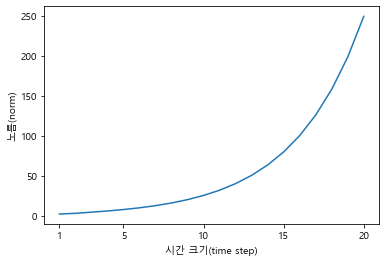

In [1]:
import numpy as np
import matplotlib.pyplot as plt
plt.rc('font', family='Malgun Gothic')

N = 2  # 미니배치 크기
H = 3  # 은닉 상태 벡터의 차원 수
T = 20 # 시계열 데이터의 길이

dh = np.ones((N,H))  # (2,3)
print('dh:\n',dh)

np.random.seed(3)   # 재현할 수 있도록 난수의 시드 고정

Wh = np.random.randn(H,H)         # 기울기 폭발 (스칼라일 경우 Wh가 1보다 큰 경우)   --> NaN, 발산
# Wh = np.random.randn(H,H)*0.5   # 기울기 소실 (스칼라일 경우 Wh가 1보다 작은 경우) --> 0 
print('Wh:\n',Wh)


# Norm은 벡터의 길이 혹은 크기를 측정하는 방법(함수)이다
# L1 norm : 벡터의 각 요소의 절대값을 모두 합한 값
# L2 norm : 각 요소의 제곱을 모두 합하여 제곱근을 취한 값
# http://taewan.kim/post/norm/
norm_list = []
for t in range(T):
    dh = np.dot(dh,Wh.T)   # 미분, gradient 값
    # print('-'*30)
    # print(dh)
    norm = np.sqrt(np.sum(dh**2))/N  # 평균 norm
    # print(norm)
    norm_list.append(norm)
    
print(norm_list)  

# 그래프 그리기
plt.plot(np.arange(len(norm_list)), norm_list)
plt.xticks([0, 4, 9, 14, 19], [1, 5, 10, 15, 20])
plt.xlabel('시간 크기(time step)')
plt.ylabel('노름(norm)')
plt.show()    

### 기울기 폭발 대책 : 기울기 클리핑(gradient cliping) 함수 구현
https://wikidocs.net/61375

In [2]:
dW1 = np.random.rand(3,3)*10
dW2 = np.random.rand(3,3)*10
print('dW1:\n',dW1)
print('dW2:\n',dW2)

grads = [dW1,dW2]

max_norm = 5.0   # threshold, 한계값

## nn_layers.py 에 추가한다
def clip_grads(grads, max_norm):
    total_norm = 0
    for grad in grads:  # L2 norm 구하기 , 제곱의 합의 제곱근
        total_norm += np.sum(grad ** 2)
    total_norm = np.sqrt(total_norm)

    rate = max_norm / (total_norm + 1e-6)
    # print('rate:',rate)
    if rate < 1:     # total_norm 이 한계값(max_norm) 보다 클경우
        for grad in grads:
            grad *= rate
    

print('(dW1) before:', dW1.flatten())
#print('(dW2) before:', dW2.flatten())
clip_grads(grads, max_norm)
print('(dw1) after:', dW1.flatten())  # 값이 약간 줄어듦    
#print('(dw2) after:', dW2.flatten())  # 값이 약간 줄어듦    

dW1:
 [[6.49144048 2.78487283 6.76254902]
 [5.90862817 0.23981882 5.58854088]
 [2.59252447 4.15101197 2.83525082]]
dW2:
 [[6.93137918 4.40453718 1.56867738]
 [5.44649018 7.80314765 3.06363532]
 [2.21957884 3.87971258 9.3638365 ]]
(dW1) before: [6.49144048 2.78487283 6.76254902 5.90862817 0.23981882 5.58854088
 2.59252447 4.15101197 2.83525082]
(dw1) after: [1.49503731 0.64138134 1.55747605 1.36081038 0.05523244 1.28709139
 0.59708178 0.95601551 0.65298384]


### 기울기 소실 방지 : Gated RNN 인 LSTM(Long Short Term Memory)이나  GRU(Gated Recurrent Units ) 사용
### LSTM  : RNN에 기억 셀 𝐜<sub>𝐭</sub> 과 , f , g, i, o 게이트 4개를 추가

In [3]:
def sigmoid(x):
    return 1 / (1 + np.exp(-x))
# nn_layers.py 에 sigmoid 함수를 추가한다

class LSTM :
    def __init__(self,Wx,Wh,b):
        self.params = [Wx,Wh,b]
        self.grads = [np.zeros_like(Wx), np.zeros_like(Wh),np.zeros_like(b)]
        self.cache = None   
        
    def forward(self, x, h_prev, c_prev):
        Wx,Wh,b = self.params              # Wx,Wh : (D,4*H)와 (H,4*H)로 각각 생성하여 입력됨
        N,H = h_prev.shape
        
        A =  np.dot(h_prev,Wh) + np.dot(x,Wx) + b  # (N,4*H)
        
        # 동일한 사이즈 4개로 슬라이싱 : f,g,i,o
        f = A[:, :H]
        g = A[:, H:2*H]
        i = A[:, 2*H:3*H]
        o = A[:, 3*H:]
        
        f = sigmoid(f)
        g = np.tanh(g)
        i = sigmoid(i)
        o = sigmoid(o)
        
        c_next = f*c_prev + g*i
        h_next = o*np.tanh(c_next)
        
        self.cache = (x,h_prev,c_prev,c_next,f,g,i,o)
        
        return h_next,c_next
    
    def backward(self, dh_next, dc_next):
        Wx,Wh,b = self.params 
        x,h_prev,c_prev,c_next,f,g,i,o = self.cache
        
        tanh_c_next = np.tanh(c_next)
        ds = dc_next + (dh_next*o) * (1 - tanh_c_next**2)
        
        dc_prev = ds * f
        
        df = ds * c_prev
        di = ds * g
        dg = ds * i
        do = dh_next * tanh_c_next
        
        # sigmoid 미분 : y*(1-y) 
        df *= f * (1 - f)
        di *= i * (1 - i)
        do *= o * (1 - o)
        
        # tanh 미분 : (1-y**2) 
        dg *= (1 - g**2)
        
        dA = np.hstack((df,dg,di,do)) # 수평으로 합치기 (slice의 역전파)
        
        dWh = np.dot(h_prev.T,dA)       # Matmul의 역전파
        dh_prev = np.dot(dA,Wh.T)
        
        dWx = np.dot(x.T,dA)            # Matmul의 역전파
        dx = np.dot(dA,Wx.T)     
        
        db = np.sum(dA,axis=0)          # repeat노드의 역전파 : sum()
        
        self.grads[0][...] = dWx
        self.grads[1][...] = dWh
        self.grads[2][...] = db           
        
        return dx, dh_prev, dc_prev

### Time LSTM 구현

In [4]:
class TimeLSTM:
    def __init__(self, Wx, Wh, b, stateful=False):
        self.params = [Wx, Wh, b]
        self.grads = [np.zeros_like(Wx),np.zeros_like(Wh),np.zeros_like(b)]
        self.layers = None
        
        self.h, self.c = None,None
        self.dh = None
        
        self.stateful = stateful
        
    def forward(self,xs):         # xs : (N,T,D)
        Wx, Wh, b = self.params   # Wx : (D,4*H)  , Wh : (H,4*H)
        N, T, D = xs.shape        # N : batch size, T : sequence length , D : input size 
        H = Wh.shape[0]           # H : hidden size
        
        self.layers = []
        hs = np.empty((N,T,H),dtype='f') # (N,T,D) * (D,H) ==> (N,T,H) 출력
        
        if not self.stateful or self.h is None:
            self.h = np.zeros((N,H),dtype='f')
 
        if not self.stateful or self.c is None:
            self.c = np.zeros((N,H),dtype='f')
            
        for t in range(T):             
            layer = LSTM(*self.params)  
            self.h , self.c = layer.forward(xs[:,t,:], self.h, self.c)  
            
            hs[:,t,:] = self.h
            self.layers.append(layer)
            
        return hs  # 출력 , (N,T,H)  
    
    def backward(self, dhs):       # dhs : (N,T,H)
        Wx, Wh, b = self.params
        N, T, H = dhs.shape
        D = Wx.shape[0]     # Wx : (D,4*H)
        
        dxs = np.empty((N,T,D), dtype='f')
        dh , dc = 0, 0
        grads = [0,0,0]
        
        for t in reversed(range(T)):
            layer = self.layers[t]
            dx,dh,dc = layer.backward(dhs[:,t,:] + dh ,dc) 
            dxs[:,t,:] = dx
            
            for i, grad in enumerate(layer.grads):  # 기울기를 합산
                grads[i] += grad 
        
        for i,grad in enumerate(grads):
            self.grads[i][...] = grad
            
        self.dh = dh 
        
        return dxs   
    
    def set_state(self,h,c=None):
        self.h, self.c = h,c
        
    def reset_state(self):
        self.h, self.c = None, None    

### LSTM을 사용한 언어 모델 : Rnnlm

In [5]:
from nn_layers import sigmoid,SGD,TimeEmbedding,TimeAffine,TimeSoftmaxWithLoss,RnnlmTrainer

In [6]:
import pickle

class Rnnlm:
    def __init__(self,vocab_size=10000, wordvec_size=100, hidden_size=100):
        V,D,H = vocab_size, wordvec_size, hidden_size
        rn = np.random.randn
        
        # 가중치 초기화
        embed_W = (rn(V,D) / 100).astype('f')       # Embediing 계층의 출력 (N,D) ---> (N,T,D)
        lstm_Wx = (rn(D,4*H) / np.sqrt(D)).astype('f') # Xavier(=Glorot) Initializer, https://gomguard.tistory.com/184
        lstm_Wh = (rn(H,4*H) / np.sqrt(H)).astype('f') # Xavier(=Glorot) Initializer
        lstm_b = np.zeros(4*H).astype('f')             # LSTM 계층의 출력 : (N,H)    --> (N,T,H)
        affine_W = (rn(H,V) / np.sqrt(H)).astype('f')
        affine_b = np.zeros(V).astype('f')          # Affine 계층의 출력 : (N,V) --> (N,T,V)
        
        # 계층생성
        self.layers = [
            TimeEmbedding(embed_W),
            TimeLSTM(lstm_Wx,lstm_Wh,lstm_b,stateful=True),
            TimeAffine(affine_W,affine_b)            
        ]
        self.loss_layer = TimeSoftmaxWithLoss()
        self.lstm_layer = self.layers[1]
        
        # 모든 가중치와 기울기를 리스트에 모은다.
        self.params,self.grads = [],[]
        for layer in self.layers:
            self.params += layer.params
            self.grads += layer.grads
            
    def predict(self,xs):
        for layer in self.layers : 
            xs = layer.forward(xs)
        return xs
            
    def forward(self,xs,ts):
        score = self.predict(xs)
        loss = self.loss_layer.forward(score,ts)
        return loss
    
    def backward(self,dout=1):
        dout = self.loss_layer.backward(dout)
        for layer in reversed(self.layers) :
            dout = layer.backward(dout)
        return dout
    
    def reset_state(self):
        self.lstm_layer.reset_state()
        
    def save_params(self, file_name='Rnnlm.pkl'):
        with open(file_name,'wb') as f:
            pickle.dump(self.params,f)
            
    def load_params(self, file_name='Rnnlm.pkl'):
        with open(file_name,'rb') as f:
            self.params = pickle.load(f)           

### 학습을 위한 코드

In [7]:
from dataset import ptb

# 하이퍼 파라미터 설정
batch_size = 20
wordvec_size = 100
hidden_size = 100   # RNN의 은닉 상태 벡터의 원소 수
time_size = 5       # Truncated BPTT가 한 번에 펼치는 시간 크기
lr = 20.0
# max_epoch = 4  #  약 30분 소요 , PPL : 약 136.07
max_epoch = 1
max_grad = 0.25  #  기울기 클리핑을 위한 threshold 값

# 학습 데이터 읽기 : 전체 데이터 사용
corpus, word_to_id, id_to_word = ptb.load_data('train')
print(len(corpus), len(word_to_id))  # 929589 , 10000

corpus_test,_,_ = ptb.load_data('test')
vocab_size = len(word_to_id)
print(vocab_size)  # 10000

xs = corpus[:-1]    # 입력 값, 마지막 단어를 제외
ts = corpus[1:]     # 출력 값(정답레이블), 첫 단어를 제외
print(xs.shape,ts.shape) 

929589 10000
10000
(929588,) (929588,)


| 에폭 1 |  반복 1 / 9295 | 시간 0[s] | 퍼플렉서티 9998.04
| 에폭 1 |  반복 21 / 9295 | 시간 0[s] | 퍼플렉서티 2743.66
| 에폭 1 |  반복 41 / 9295 | 시간 1[s] | 퍼플렉서티 1424.40
| 에폭 1 |  반복 61 / 9295 | 시간 2[s] | 퍼플렉서티 1053.62
| 에폭 1 |  반복 81 / 9295 | 시간 2[s] | 퍼플렉서티 930.13
| 에폭 1 |  반복 101 / 9295 | 시간 3[s] | 퍼플렉서티 688.88
| 에폭 1 |  반복 121 / 9295 | 시간 4[s] | 퍼플렉서티 839.19
| 에폭 1 |  반복 141 / 9295 | 시간 5[s] | 퍼플렉서티 734.00
| 에폭 1 |  반복 161 / 9295 | 시간 5[s] | 퍼플렉서티 751.91
| 에폭 1 |  반복 181 / 9295 | 시간 6[s] | 퍼플렉서티 587.93
| 에폭 1 |  반복 201 / 9295 | 시간 7[s] | 퍼플렉서티 556.49
| 에폭 1 |  반복 221 / 9295 | 시간 8[s] | 퍼플렉서티 558.26
| 에폭 1 |  반복 241 / 9295 | 시간 8[s] | 퍼플렉서티 609.50
| 에폭 1 |  반복 261 / 9295 | 시간 9[s] | 퍼플렉서티 588.51
| 에폭 1 |  반복 281 / 9295 | 시간 10[s] | 퍼플렉서티 510.21
| 에폭 1 |  반복 301 / 9295 | 시간 11[s] | 퍼플렉서티 411.44
| 에폭 1 |  반복 321 / 9295 | 시간 11[s] | 퍼플렉서티 499.41
| 에폭 1 |  반복 341 / 9295 | 시간 12[s] | 퍼플렉서티 405.68
| 에폭 1 |  반복 361 / 9295 | 시간 13[s] | 퍼플렉서티 445.31
| 에폭 1 |  반복 381 / 9295 | 시간 14[s] | 퍼플렉서티 452.22
| 에폭 1 |  반복 401

| 에폭 1 |  반복 3241 / 9295 | 시간 131[s] | 퍼플렉서티 243.30
| 에폭 1 |  반복 3261 / 9295 | 시간 132[s] | 퍼플렉서티 241.75
| 에폭 1 |  반복 3281 / 9295 | 시간 133[s] | 퍼플렉서티 233.75
| 에폭 1 |  반복 3301 / 9295 | 시간 134[s] | 퍼플렉서티 220.27
| 에폭 1 |  반복 3321 / 9295 | 시간 134[s] | 퍼플렉서티 214.15
| 에폭 1 |  반복 3341 / 9295 | 시간 135[s] | 퍼플렉서티 185.99
| 에폭 1 |  반복 3361 / 9295 | 시간 136[s] | 퍼플렉서티 181.62
| 에폭 1 |  반복 3381 / 9295 | 시간 137[s] | 퍼플렉서티 197.62
| 에폭 1 |  반복 3401 / 9295 | 시간 137[s] | 퍼플렉서티 218.00
| 에폭 1 |  반복 3421 / 9295 | 시간 138[s] | 퍼플렉서티 216.59
| 에폭 1 |  반복 3441 / 9295 | 시간 139[s] | 퍼플렉서티 273.12
| 에폭 1 |  반복 3461 / 9295 | 시간 140[s] | 퍼플렉서티 261.68
| 에폭 1 |  반복 3481 / 9295 | 시간 140[s] | 퍼플렉서티 261.79
| 에폭 1 |  반복 3501 / 9295 | 시간 141[s] | 퍼플렉서티 221.82
| 에폭 1 |  반복 3521 / 9295 | 시간 142[s] | 퍼플렉서티 285.12
| 에폭 1 |  반복 3541 / 9295 | 시간 143[s] | 퍼플렉서티 277.96
| 에폭 1 |  반복 3561 / 9295 | 시간 143[s] | 퍼플렉서티 274.82
| 에폭 1 |  반복 3581 / 9295 | 시간 144[s] | 퍼플렉서티 209.30
| 에폭 1 |  반복 3601 / 9295 | 시간 145[s] | 퍼플렉서티 201.58
| 에폭 1 |  반복

| 에폭 1 |  반복 6401 / 9295 | 시간 257[s] | 퍼플렉서티 227.69
| 에폭 1 |  반복 6421 / 9295 | 시간 258[s] | 퍼플렉서티 200.09
| 에폭 1 |  반복 6441 / 9295 | 시간 259[s] | 퍼플렉서티 183.63
| 에폭 1 |  반복 6461 / 9295 | 시간 259[s] | 퍼플렉서티 193.90
| 에폭 1 |  반복 6481 / 9295 | 시간 260[s] | 퍼플렉서티 171.82
| 에폭 1 |  반복 6501 / 9295 | 시간 261[s] | 퍼플렉서티 192.67
| 에폭 1 |  반복 6521 / 9295 | 시간 262[s] | 퍼플렉서티 254.82
| 에폭 1 |  반복 6541 / 9295 | 시간 263[s] | 퍼플렉서티 266.85
| 에폭 1 |  반복 6561 / 9295 | 시간 264[s] | 퍼플렉서티 228.15
| 에폭 1 |  반복 6581 / 9295 | 시간 264[s] | 퍼플렉서티 169.60
| 에폭 1 |  반복 6601 / 9295 | 시간 265[s] | 퍼플렉서티 189.13
| 에폭 1 |  반복 6621 / 9295 | 시간 266[s] | 퍼플렉서티 225.96
| 에폭 1 |  반복 6641 / 9295 | 시간 267[s] | 퍼플렉서티 199.97
| 에폭 1 |  반복 6661 / 9295 | 시간 268[s] | 퍼플렉서티 198.83
| 에폭 1 |  반복 6681 / 9295 | 시간 269[s] | 퍼플렉서티 243.12
| 에폭 1 |  반복 6701 / 9295 | 시간 269[s] | 퍼플렉서티 253.61
| 에폭 1 |  반복 6721 / 9295 | 시간 270[s] | 퍼플렉서티 221.28
| 에폭 1 |  반복 6741 / 9295 | 시간 271[s] | 퍼플렉서티 189.50
| 에폭 1 |  반복 6761 / 9295 | 시간 272[s] | 퍼플렉서티 161.48
| 에폭 1 |  반복

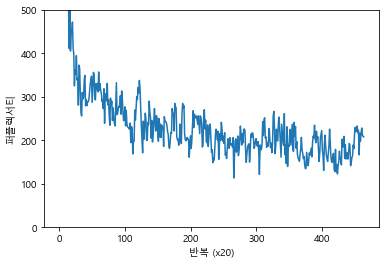

In [8]:
# 모델 생성
model = Rnnlm(vocab_size,wordvec_size,hidden_size)
optimizer = SGD(lr)
trainer = RnnlmTrainer(model,optimizer)

# 기울기 클리핑을 적용하여 학습
trainer.fit(xs,ts,max_epoch, batch_size, time_size, max_grad,eval_interval=20)
trainer.plot(ylim=(0,500))

In [9]:
import sys
def eval_perplexity(model, corpus, batch_size=10, time_size=35):
    print('퍼플렉서티 평가 중 ...')
    corpus_size = len(corpus)
    total_loss, loss_cnt = 0, 0
    max_iters = (corpus_size - 1) // (batch_size * time_size)
    jump = (corpus_size - 1) // batch_size

    for iters in range(max_iters):
        xs = np.zeros((batch_size, time_size), dtype=np.int32)
        ts = np.zeros((batch_size, time_size), dtype=np.int32)
        time_offset = iters * time_size
        offsets = [time_offset + (i * jump) for i in range(batch_size)]
        for t in range(time_size):
            for i, offset in enumerate(offsets):
                xs[i, t] = corpus[(offset + t) % corpus_size]
                ts[i, t] = corpus[(offset + t + 1) % corpus_size]

        try:
            loss = model.forward(xs, ts, train_flg=False)
        except TypeError:
            loss = model.forward(xs, ts)
        total_loss += loss

        sys.stdout.write('\r%d / %d' % (iters, max_iters))
        sys.stdout.flush()

    print('')
    ppl = np.exp(total_loss / max_iters)
    return ppl

In [10]:
# 테스트 데이터로 평가
model.reset_state()
ppl_test = eval_perplexity(model, corpus_test)  # test 데이터로 평가
print('테스트 퍼플렉서티: ', ppl_test)

# 매개변수 저장
model.save_params()


퍼플렉서티 평가 중 ...
234 / 235
테스트 퍼플렉서티:  206.09676330158777


### 개선된 RNNLM 구현

In [11]:
class BetterRnnlm():
    '''
     LSTM 계층을 2개 사용하고 각 층에 드롭아웃을 적용한 모델이다.
     아래 [1]에서 제안한 모델을 기초로 하였고, [2]와 [3]의 가중치 공유(weight tying)를 적용했다.

     [1] Recurrent Neural Network Regularization (https://arxiv.org/abs/1409.2329)
     [2] Using the Output Embedding to Improve Language Models (https://arxiv.org/abs/1608.05859)
     [3] Tying Word Vectors and Word Classifiers (https://arxiv.org/pdf/1611.01462.pdf)
    '''
    def __init__(self,vocab_size=10000, wordvec_size=100, hidden_size=100,dropout_ratio=0.5):
        V,D,H = vocab_size, wordvec_size, hidden_size
        rn = np.random.randn
        
        # 가중치 초기화
        embed_W = (rn(V,D) / 100).astype('f')            # Affine 계층과 가중치 공유  
        lstm_Wx1 = (rn(D,4*H) / np.sqrt(D)).astype('f')  # Wx1 : (D,4*H) 
        lstm_Wh1 = (rn(H,4*H) / np.sqrt(H)).astype('f') 
        lstm_b1 = np.zeros(4*H).astype('f')  
        lstm_Wx2 = (rn(H,4*H) / np.sqrt(H)).astype('f')  # Wx2 : (H,4*H) 
        lstm_Wh2 = (rn(H,4*H) / np.sqrt(H)).astype('f') 
        lstm_b2 = np.zeros(4*H).astype('f')             
        
        # affine_W = (rn(H,V) / np.sqrt(H)).astype('f')  # 사용하지 않음
        affine_b = np.zeros(V).astype('f')          
        
        # 계층생성
        self.layers = [
            TimeEmbedding(embed_W),      # (V,D)
            TimeDropout(dropout_ratio),
            TimeLSTM(lstm_Wx1,lstm_Wh1,lstm_b1,stateful=True),
            TimeDropout(dropout_ratio),            
            TimeLSTM(lstm_Wx2,lstm_Wh2,lstm_b2,stateful=True),
            TimeDropout(dropout_ratio),            
            TimeAffine(embed_W.T,affine_b)  # embed_W.T : (D,V), D=H=650 이므로 (H,V)와 같음, weight tying!!                  
        ]
        self.loss_layer = TimeSoftmaxWithLoss()
        self.lstm_layers = [self.layers[2],self.layers[4]]
        self.drop_layers = [self.layers[1],self.layers[3],self.layers[5]]
        
        # 모든 가중치와 기울기를 리스트에 모은다.
        self.params,self.grads = [],[]
        for layer in self.layers:
            self.params += layer.params
            self.grads += layer.grads
            
    def predict(self,xs,train_flag=False):
        for layer in self.drop_layers:    # 예측 시에는 dropout을 사용하지 않도록 플래그를 설정
            layer.train_flag = train_flag
            
        for layer in self.layers :    # 7회 반복
            xs = layer.forward(xs)
        return xs
            
    def forward(self,xs,ts,train_flag=True):
        score = self.predict(xs,train_flag) # 학습 시에는 dropout을 사용하도록 플래그를 설정
        loss = self.loss_layer.forward(score,ts)
        return loss
    
    def backward(self,dout=1):
        dout = self.loss_layer.backward(dout)
        for layer in reversed(self.layers) : # 7회
            dout = layer.backward(dout)
        return dout
    
    def reset_state(self):
        for layer in self.lstm_layers: # 2회
            layer.reset_state()
        
    def save_params(self, file_name='BetterRnnlm.pkl'):
        with open(file_name,'wb') as f:
            pickle.dump(self.params,f)
            
    def load_params(self, file_name='BetterRnnlm.pkl'):
        with open(file_name,'rb') as f:
            self.params = pickle.load(f)               

In [15]:
# TimeDropout 클래스
# https://www.tensorflow.org/api_docs/python/tf/keras/layers/Dropout
# dropout 된 입력 데이터는 0이 된다
# dropout 되지 않은 입력 데이터는  1/(1 - rate)을 곱하여 scale up 시킨다 (droput rate:0~1)

# nn_layers.py에 추가

class TimeDropout:
    def __init__(self,dropout_ratio=0.5):
        self.params,self.grads= [],[]
        self.dropout_ratio = dropout_ratio
        self.mask = None
        self.train_flag = True  # 학습시에만 True로 설정하여 dropout 적용, 예측시에는 사용하지 않음
        
    def forward(self,xs):
        if self.train_flag:  # True인 경우: 학습시
            flg = np.random.rand(*xs.shape) > self.dropout_ratio
            scale = 1.0 / (1.0 - self.dropout_ratio)
            self.mask = flg.astype(np.float32)*scale
            return xs * self.mask
        else :
            return xs
        
    def backward(self,dout):
        return  dout*self.mask

In [22]:
dropout_ratio = 0.5
dr = TimeDropout(dropout_ratio)

xs = np.arange(1,10).reshape(3,3)
print('xs:\n',xs)

# dr.train_flg = True
drop_xs = dr.forward(xs)
print('drop_xs:\n',drop_xs)

print('-'*30)
flg = np.random.rand(*xs.shape) > dropout_ratio    
print('flg:\n',flg)
print(xs*flg)

xs:
 [[1 2 3]
 [4 5 6]
 [7 8 9]]
drop_xs:
 [[ 0.  0.  6.]
 [ 0. 10. 12.]
 [14.  0. 18.]]
------------------------------
flg:
 [[False False False]
 [False  True  True]
 [ True  True False]]
[[0 0 0]
 [0 5 6]
 [7 8 0]]


### 학습코드 구현

In [23]:
# 하이퍼파라미터 설정
batch_size = 20
wordvec_size = 100
hidden_size = 100  # RNN의 은닉 상태 벡터의 원소 수
time_size = 5  # RNN을 펼치는 크기
lr = 20.0
# max_epoch = 40  #  약 2일 소요 , PPL : 약 75.76
max_epoch = 1
max_grad = 0.25  #  기울기 클리핑을 위한 threshold 값
dropout = 0.5

# 학습 데이터 읽기 : 전체 데이터 사용
corpus, word_to_id, id_to_word = ptb.load_data('train')
corpus_val,_,_ = ptb.load_data('val')
corpus_test,_,_ = ptb.load_data('test')

vocab_size = len(word_to_id)

xs = corpus[:-1]  # 입력
ts = corpus[1:]   # 출력（정답 레이블）

Done


In [24]:
# 모델 생성
model = BetterRnnlm(vocab_size, wordvec_size, hidden_size)
optimizer = SGD(lr)
trainer = RnnlmTrainer(model, optimizer)

best_ppl = float('inf')
for epoch in range(max_epoch):
    trainer.fit(xs, ts, max_epoch=1, batch_size=batch_size,
                time_size=time_size, max_grad=max_grad)

    model.reset_state()
    ppl = eval_perplexity(model, corpus_val)
    print('검증 퍼플렉서티: ', ppl)

    if best_ppl > ppl:
        best_ppl = ppl
        model.save_params()
    else:
        lr /= 4.0
        optimizer.lr = lr

    model.reset_state()
    print('-' * 50)

| 에폭 1 |  반복 1 / 9295 | 시간 0[s] | 퍼플렉서티 10000.17
| 에폭 1 |  반복 21 / 9295 | 시간 0[s] | 퍼플렉서티 2524.77
| 에폭 1 |  반복 41 / 9295 | 시간 1[s] | 퍼플렉서티 1550.05
| 에폭 1 |  반복 61 / 9295 | 시간 2[s] | 퍼플렉서티 1154.59
| 에폭 1 |  반복 81 / 9295 | 시간 3[s] | 퍼플렉서티 999.02
| 에폭 1 |  반복 101 / 9295 | 시간 3[s] | 퍼플렉서티 784.85
| 에폭 1 |  반복 121 / 9295 | 시간 4[s] | 퍼플렉서티 962.50
| 에폭 1 |  반복 141 / 9295 | 시간 5[s] | 퍼플렉서티 861.11
| 에폭 1 |  반복 161 / 9295 | 시간 6[s] | 퍼플렉서티 870.00
| 에폭 1 |  반복 181 / 9295 | 시간 6[s] | 퍼플렉서티 690.82
| 에폭 1 |  반복 201 / 9295 | 시간 7[s] | 퍼플렉서티 663.64
| 에폭 1 |  반복 221 / 9295 | 시간 8[s] | 퍼플렉서티 679.47
| 에폭 1 |  반복 241 / 9295 | 시간 9[s] | 퍼플렉서티 735.86
| 에폭 1 |  반복 261 / 9295 | 시간 10[s] | 퍼플렉서티 726.77
| 에폭 1 |  반복 281 / 9295 | 시간 11[s] | 퍼플렉서티 664.85
| 에폭 1 |  반복 301 / 9295 | 시간 11[s] | 퍼플렉서티 542.30
| 에폭 1 |  반복 321 / 9295 | 시간 12[s] | 퍼플렉서티 627.29
| 에폭 1 |  반복 341 / 9295 | 시간 13[s] | 퍼플렉서티 533.88
| 에폭 1 |  반복 361 / 9295 | 시간 14[s] | 퍼플렉서티 588.44
| 에폭 1 |  반복 381 / 9295 | 시간 15[s] | 퍼플렉서티 583.61
| 에폭 1 |  반복 4

| 에폭 1 |  반복 3221 / 9295 | 시간 144[s] | 퍼플렉서티 444.41
| 에폭 1 |  반복 3241 / 9295 | 시간 145[s] | 퍼플렉서티 443.51
| 에폭 1 |  반복 3261 / 9295 | 시간 146[s] | 퍼플렉서티 456.14
| 에폭 1 |  반복 3281 / 9295 | 시간 147[s] | 퍼플렉서티 436.31
| 에폭 1 |  반복 3301 / 9295 | 시간 149[s] | 퍼플렉서티 427.02
| 에폭 1 |  반복 3321 / 9295 | 시간 150[s] | 퍼플렉서티 410.60
| 에폭 1 |  반복 3341 / 9295 | 시간 151[s] | 퍼플렉서티 370.47
| 에폭 1 |  반복 3361 / 9295 | 시간 152[s] | 퍼플렉서티 340.21
| 에폭 1 |  반복 3381 / 9295 | 시간 153[s] | 퍼플렉서티 360.20
| 에폭 1 |  반복 3401 / 9295 | 시간 154[s] | 퍼플렉서티 408.29
| 에폭 1 |  반복 3421 / 9295 | 시간 155[s] | 퍼플렉서티 373.03
| 에폭 1 |  반복 3441 / 9295 | 시간 156[s] | 퍼플렉서티 488.34
| 에폭 1 |  반복 3461 / 9295 | 시간 157[s] | 퍼플렉서티 455.41
| 에폭 1 |  반복 3481 / 9295 | 시간 158[s] | 퍼플렉서티 460.46
| 에폭 1 |  반복 3501 / 9295 | 시간 159[s] | 퍼플렉서티 406.77
| 에폭 1 |  반복 3521 / 9295 | 시간 160[s] | 퍼플렉서티 490.06
| 에폭 1 |  반복 3541 / 9295 | 시간 161[s] | 퍼플렉서티 453.13
| 에폭 1 |  반복 3561 / 9295 | 시간 162[s] | 퍼플렉서티 491.07
| 에폭 1 |  반복 3581 / 9295 | 시간 163[s] | 퍼플렉서티 381.17
| 에폭 1 |  반복

C:\Users\storm\Desktop\01_고급과정_주말반\05_RNN_LSTM\nn_layers.py:48: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-x))


| 에폭 1 |  반복 5481 / 9295 | 시간 262[s] | 퍼플렉서티 349.64
| 에폭 1 |  반복 5501 / 9295 | 시간 263[s] | 퍼플렉서티 401.61
| 에폭 1 |  반복 5521 / 9295 | 시간 264[s] | 퍼플렉서티 438.94
| 에폭 1 |  반복 5541 / 9295 | 시간 265[s] | 퍼플렉서티 412.73
| 에폭 1 |  반복 5561 / 9295 | 시간 266[s] | 퍼플렉서티 388.96
| 에폭 1 |  반복 5581 / 9295 | 시간 268[s] | 퍼플렉서티 408.38
| 에폭 1 |  반복 5601 / 9295 | 시간 269[s] | 퍼플렉서티 388.89
| 에폭 1 |  반복 5621 / 9295 | 시간 270[s] | 퍼플렉서티 427.35
| 에폭 1 |  반복 5641 / 9295 | 시간 271[s] | 퍼플렉서티 434.83
| 에폭 1 |  반복 5661 / 9295 | 시간 272[s] | 퍼플렉서티 425.61
| 에폭 1 |  반복 5681 / 9295 | 시간 273[s] | 퍼플렉서티 324.29
| 에폭 1 |  반복 5701 / 9295 | 시간 275[s] | 퍼플렉서티 318.17
| 에폭 1 |  반복 5721 / 9295 | 시간 276[s] | 퍼플렉서티 336.40
| 에폭 1 |  반복 5741 / 9295 | 시간 277[s] | 퍼플렉서티 376.16
| 에폭 1 |  반복 5761 / 9295 | 시간 278[s] | 퍼플렉서티 393.36
| 에폭 1 |  반복 5781 / 9295 | 시간 279[s] | 퍼플렉서티 417.61
| 에폭 1 |  반복 5801 / 9295 | 시간 280[s] | 퍼플렉서티 315.78
| 에폭 1 |  반복 5821 / 9295 | 시간 281[s] | 퍼플렉서티 369.83
| 에폭 1 |  반복 5841 / 9295 | 시간 282[s] | 퍼플렉서티 412.00
| 에폭 1 |  반복

| 에폭 1 |  반복 8641 / 9295 | 시간 430[s] | 퍼플렉서티 375.15
| 에폭 1 |  반복 8661 / 9295 | 시간 431[s] | 퍼플렉서티 401.13
| 에폭 1 |  반복 8681 / 9295 | 시간 433[s] | 퍼플렉서티 413.04
| 에폭 1 |  반복 8701 / 9295 | 시간 434[s] | 퍼플렉서티 357.57
| 에폭 1 |  반복 8721 / 9295 | 시간 435[s] | 퍼플렉서티 376.58
| 에폭 1 |  반복 8741 / 9295 | 시간 436[s] | 퍼플렉서티 327.85
| 에폭 1 |  반복 8761 / 9295 | 시간 437[s] | 퍼플렉서티 338.99
| 에폭 1 |  반복 8781 / 9295 | 시간 438[s] | 퍼플렉서티 341.01
| 에폭 1 |  반복 8801 / 9295 | 시간 439[s] | 퍼플렉서티 344.69
| 에폭 1 |  반복 8821 / 9295 | 시간 440[s] | 퍼플렉서티 359.16
| 에폭 1 |  반복 8841 / 9295 | 시간 441[s] | 퍼플렉서티 365.41
| 에폭 1 |  반복 8861 / 9295 | 시간 442[s] | 퍼플렉서티 381.76
| 에폭 1 |  반복 8881 / 9295 | 시간 443[s] | 퍼플렉서티 334.96
| 에폭 1 |  반복 8901 / 9295 | 시간 444[s] | 퍼플렉서티 342.66
| 에폭 1 |  반복 8921 / 9295 | 시간 445[s] | 퍼플렉서티 328.81
| 에폭 1 |  반복 8941 / 9295 | 시간 446[s] | 퍼플렉서티 364.07
| 에폭 1 |  반복 8961 / 9295 | 시간 447[s] | 퍼플렉서티 433.29
| 에폭 1 |  반복 8981 / 9295 | 시간 448[s] | 퍼플렉서티 374.81
| 에폭 1 |  반복 9001 / 9295 | 시간 449[s] | 퍼플렉서티 452.20
| 에폭 1 |  반복

In [25]:
# 테스트 데이터로 평가
model.reset_state()
ppl_test = eval_perplexity(model, corpus_test)
print('테스트 퍼플렉서티: ', ppl_test)

퍼플렉서티 평가 중 ...
234 / 235
테스트 퍼플렉서티:  391.34538654333835
